In [26]:
#Install Dependacies

!pip install torch torchvision torchaudio

In [2]:
!pip list

Package                                           Version     Editable project location
------------------------------------------------- ----------- ----------------------------------------------
absl-py                                           2.0.0
accelerate                                        0.23.0
aiobotocore                                       2.5.0
aiofiles                                          22.1.0
aiohttp                                           3.8.3
aioitertools                                      0.7.1
aiosignal                                         1.2.0
aiosqlite                                         0.18.0
alabaster                                         0.7.12
altair                                            5.1.1
anaconda-anon-usage                               0.4.1
anaconda-catalogs                                 0.2.0
anaconda-client                                   1.12.0
anaconda-cloud-auth                               0.1.3
anaconda-navig

ply                                               3.11
pooch                                             1.4.0
poyo                                              0.5.0
pretty-midi                                       0.2.10
prometheus-client                                 0.14.1
prompt-toolkit                                    3.0.36
Protego                                           0.1.16
protobuf                                          3.20.3
psutil                                            5.9.0
psycopg2                                          2.9.9
ptyprocess                                        0.7.0
pure-eval                                         0.2.2
py-cpuinfo                                        8.0.0
pyarrow                                           11.0.0
pyasn1                                            0.4.8
pyasn1-modules                                    0.2.8
PyAutoGUI                                         0.9.54
pycodestyle                               

In [25]:
!pip install 'stable-baselines3[extra]' 'protobuf==3.20.*'


In [80]:
!pip install mss pydirectinput pytesseract


In [24]:
!pip install gym


In [66]:
from mss import mss
import pyautogui
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

In [67]:
# Create Enviroment

class WebGame(Env):
    
    # setup the enviroment action and observation shapes
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 450, 'left': 390, 'width': 660, 'height': 70}
    
    # call to do something
    def step(self, action):
        action_map = {
            0: 'space',
            1: 'down', 
            2: 'no_op'
        }
        if action != 2:
            pyautogui.press(action_map[action])

        done, done_cap = self.get_done()
        observation = self.get_observation()
        reward = 1
        info = {}
        terminated = done  # Use the 'done' flag to indicate if the episode is terminated
        truncated = False  # This flag indicates if the episode was truncated (e.g., through a time limit)
        return observation, reward, terminated, truncated, info

    
    # visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location)))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # restart the game
    # restart the game
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # If your environment inherits from gym.Env, you might need to call super().reset(seed=seed) to properly handle seeding.
        time.sleep(1)
        pyautogui.click(x=150, y=300)  # Simulate mouse click at position (150, 300)
        pyautogui.press('space')  # Simulate pressing the spacebar
        observation = self.get_observation()
        return observation, {}  # Return observation and an empty info dictionary

    
    # get the part of the observation of the game
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    # closes down the observation
    def close(self):
        cv2.destroyAllWindows()

    
    # get done text
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap
    
    

In [47]:
env = WebGame()

In [49]:
# Testing

for episode in range(10): 
    obs, info = env.reset()  # Adjusted to match the new reset signature
    terminated = False  # Initialize terminated flag
    truncated = False  # Initialize truncated flag
    total_reward = 0
    while not terminated and not truncated:  # Check both flags
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')


Total Reward for episode 0 is 19
Total Reward for episode 1 is 20
Total Reward for episode 2 is 21
Total Reward for episode 3 is 19
Total Reward for episode 4 is 21
Total Reward for episode 5 is 21
Total Reward for episode 6 is 20
Total Reward for episode 7 is 19
Total Reward for episode 8 is 21
Total Reward for episode 9 is 20


In [68]:
# Callback

# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [51]:
env_checker.check_env(env)

In [69]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [70]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [71]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)


In [72]:
# Build and Train DQN

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [73]:
env = WebGame()


In [74]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=80000, learning_starts=0)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [75]:
model.learn(total_timesteps=88000, callback=callback)

Logging to ./logs/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.2     |
|    ep_rew_mean      | 19.2     |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 26       |
|    total_timesteps  | 77       |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.028    |
|    n_updates        | 19       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.4     |
|    ep_rew_mean      | 20.4     |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3        |
|    time_elapsed     | 52       |
|    total_timesteps  | 163      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00539

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.4     |
|    ep_rew_mean      | 21.4     |
|    exploration_rate | 0.843    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 3        |
|    time_elapsed     | 464      |
|    total_timesteps  | 1457     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21e-05 |
|    n_updates        | 364      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.5     |
|    ep_rew_mean      | 21.5     |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 3        |
|    time_elapsed     | 492      |
|    total_timesteps  | 1546     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.1     |
|    ep_rew_mean      | 24.1     |
|    exploration_rate | 0.671    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 3        |
|    time_elapsed     | 905      |
|    total_timesteps  | 3043     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.87e-06 |
|    n_updates        | 760      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.2     |
|    ep_rew_mean      | 24.2     |
|    exploration_rate | 0.663    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 3        |
|    time_elapsed     | 929      |
|    total_timesteps  | 3124     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.43e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.5     |
|    ep_rew_mean      | 27.5     |
|    exploration_rate | 0.479    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 3        |
|    time_elapsed     | 1359     |
|    total_timesteps  | 4827     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.18e-05 |
|    n_updates        | 1206     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.5     |
|    ep_rew_mean      | 27.5     |
|    exploration_rate | 0.467    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 3        |
|    time_elapsed     | 1384     |
|    total_timesteps  | 4934     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.46e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | 29.3     |
|    exploration_rate | 0.271    |
| time/               |          |
|    episodes         | 260      |
|    fps              | 3        |
|    time_elapsed     | 1832     |
|    total_timesteps  | 6750     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.77e-06 |
|    n_updates        | 1687     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.9     |
|    ep_rew_mean      | 28.9     |
|    exploration_rate | 0.261    |
| time/               |          |
|    episodes         | 264      |
|    fps              | 3        |
|    time_elapsed     | 1859     |
|    total_timesteps  | 6846     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.59e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 31.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 324      |
|    fps              | 3        |
|    time_elapsed     | 2323     |
|    total_timesteps  | 8832     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61e-05 |
|    n_updates        | 2207     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.7     |
|    ep_rew_mean      | 31.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 3        |
|    time_elapsed     | 2356     |
|    total_timesteps  | 8977     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.97e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 34.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 388      |
|    fps              | 3        |
|    time_elapsed     | 2803     |
|    total_timesteps  | 10893    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00715  |
|    n_updates        | 2723     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.9     |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 3        |
|    time_elapsed     | 2844     |
|    total_timesteps  | 11056    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0465   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.9     |
|    ep_rew_mean      | 26.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 3        |
|    time_elapsed     | 3231     |
|    total_timesteps  | 12677    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0418   |
|    n_updates        | 3169     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27       |
|    ep_rew_mean      | 27       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 3        |
|    time_elapsed     | 3256     |
|    total_timesteps  | 12781    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.028    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.4     |
|    ep_rew_mean      | 30.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 516      |
|    fps              | 4        |
|    time_elapsed     | 3677     |
|    total_timesteps  | 14755    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0289   |
|    n_updates        | 3688     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 31.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 520      |
|    fps              | 4        |
|    time_elapsed     | 3711     |
|    total_timesteps  | 14947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0193   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.5     |
|    ep_rew_mean      | 28.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 4        |
|    time_elapsed     | 4124     |
|    total_timesteps  | 16680    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00185  |
|    n_updates        | 4169     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.4     |
|    ep_rew_mean      | 28.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 584      |
|    fps              | 4        |
|    time_elapsed     | 4148     |
|    total_timesteps  | 16767    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00334  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.5     |
|    ep_rew_mean      | 28.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 644      |
|    fps              | 4        |
|    time_elapsed     | 4572     |
|    total_timesteps  | 18404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0252   |
|    n_updates        | 4600     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.8     |
|    ep_rew_mean      | 27.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 4        |
|    time_elapsed     | 4596     |
|    total_timesteps  | 18494    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00179  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.3     |
|    ep_rew_mean      | 26.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 708      |
|    fps              | 4        |
|    time_elapsed     | 4991     |
|    total_timesteps  | 20030    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0301   |
|    n_updates        | 5007     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.9     |
|    ep_rew_mean      | 25.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 712      |
|    fps              | 4        |
|    time_elapsed     | 5015     |
|    total_timesteps  | 20103    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0332   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.9     |
|    ep_rew_mean      | 27.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 772      |
|    fps              | 4        |
|    time_elapsed     | 5463     |
|    total_timesteps  | 21978    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0608   |
|    n_updates        | 5494     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.1     |
|    ep_rew_mean      | 28.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 776      |
|    fps              | 4        |
|    time_elapsed     | 5488     |
|    total_timesteps  | 22087    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00748  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 29.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 836      |
|    fps              | 4        |
|    time_elapsed     | 5907     |
|    total_timesteps  | 23832    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0191   |
|    n_updates        | 5957     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.9     |
|    ep_rew_mean      | 29.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 4        |
|    time_elapsed     | 5937     |
|    total_timesteps  | 23974    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0986   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 36.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 900      |
|    fps              | 4        |
|    time_elapsed     | 6497     |
|    total_timesteps  | 26376    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00596  |
|    n_updates        | 6593     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 36.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 904      |
|    fps              | 4        |
|    time_elapsed     | 6524     |
|    total_timesteps  | 26491    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0455   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.2     |
|    ep_rew_mean      | 40.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 964      |
|    fps              | 4        |
|    time_elapsed     | 7052     |
|    total_timesteps  | 28760    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0323   |
|    n_updates        | 7189     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42       |
|    ep_rew_mean      | 42       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 968      |
|    fps              | 4        |
|    time_elapsed     | 7113     |
|    total_timesteps  | 29044    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.048    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.1     |
|    ep_rew_mean      | 42.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1028     |
|    fps              | 4        |
|    time_elapsed     | 7694     |
|    total_timesteps  | 31584    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00627  |
|    n_updates        | 7895     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.9     |
|    ep_rew_mean      | 42.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 4        |
|    time_elapsed     | 7741     |
|    total_timesteps  | 31800    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0396   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47       |
|    ep_rew_mean      | 47       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1092     |
|    fps              | 4        |
|    time_elapsed     | 8311     |
|    total_timesteps  | 34412    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.157    |
|    n_updates        | 8602     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47       |
|    ep_rew_mean      | 47       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 4        |
|    time_elapsed     | 8349     |
|    total_timesteps  | 34596    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00469  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.1     |
|    ep_rew_mean      | 48.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1156     |
|    fps              | 4        |
|    time_elapsed     | 8972     |
|    total_timesteps  | 37443    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.141    |
|    n_updates        | 9360     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.7     |
|    ep_rew_mean      | 48.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 4        |
|    time_elapsed     | 9029     |
|    total_timesteps  | 37708    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0511   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.2     |
|    ep_rew_mean      | 54.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 4        |
|    time_elapsed     | 9767     |
|    total_timesteps  | 41187    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0557   |
|    n_updates        | 10296    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.7     |
|    ep_rew_mean      | 54.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 4        |
|    time_elapsed     | 9814     |
|    total_timesteps  | 41421    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00942  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 67.2     |
|    ep_rew_mean      | 67.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1284     |
|    fps              | 4        |
|    time_elapsed     | 10715    |
|    total_timesteps  | 45652    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.042    |
|    n_updates        | 11412    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 68       |
|    ep_rew_mean      | 68       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 4        |
|    time_elapsed     | 10768    |
|    total_timesteps  | 45901    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0104   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 68.2     |
|    ep_rew_mean      | 68.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1348     |
|    fps              | 4        |
|    time_elapsed     | 11586    |
|    total_timesteps  | 49852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0136   |
|    n_updates        | 12462    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 67.8     |
|    ep_rew_mean      | 67.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 4        |
|    time_elapsed     | 11630    |
|    total_timesteps  | 50050    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.072    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 61.8     |
|    ep_rew_mean      | 61.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 4        |
|    time_elapsed     | 12447    |
|    total_timesteps  | 53645    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0747   |
|    n_updates        | 13411    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 61.2     |
|    ep_rew_mean      | 61.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 4        |
|    time_elapsed     | 12480    |
|    total_timesteps  | 53780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.176    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54       |
|    ep_rew_mean      | 54       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1476     |
|    fps              | 4        |
|    time_elapsed     | 13199    |
|    total_timesteps  | 56871    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.149    |
|    n_updates        | 14217    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53       |
|    ep_rew_mean      | 53       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 4        |
|    time_elapsed     | 13252    |
|    total_timesteps  | 57095    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0129   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.9     |
|    ep_rew_mean      | 53.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 4        |
|    time_elapsed     | 14013    |
|    total_timesteps  | 60373    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 15093    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 53.9     |
|    ep_rew_mean      | 53.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 4        |
|    time_elapsed     | 14046    |
|    total_timesteps  | 60513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.136    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 64.5     |
|    ep_rew_mean      | 64.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1604     |
|    fps              | 4        |
|    time_elapsed     | 15035    |
|    total_timesteps  | 64772    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.204    |
|    n_updates        | 16192    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 65.6     |
|    ep_rew_mean      | 65.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 4        |
|    time_elapsed     | 15107    |
|    total_timesteps  | 65080    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0268   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 72.7     |
|    ep_rew_mean      | 72.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1668     |
|    fps              | 4        |
|    time_elapsed     | 16116    |
|    total_timesteps  | 69707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.225    |
|    n_updates        | 17426    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 73.8     |
|    ep_rew_mean      | 73.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 4        |
|    time_elapsed     | 16181    |
|    total_timesteps  | 70006    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 72.9     |
|    ep_rew_mean      | 72.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1732     |
|    fps              | 4        |
|    time_elapsed     | 17087    |
|    total_timesteps  | 74033    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.215    |
|    n_updates        | 18508    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 72.6     |
|    ep_rew_mean      | 72.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 4        |
|    time_elapsed     | 17130    |
|    total_timesteps  | 74222    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00681  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 63.9     |
|    ep_rew_mean      | 63.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1796     |
|    fps              | 4        |
|    time_elapsed     | 18016    |
|    total_timesteps  | 78167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.119    |
|    n_updates        | 19541    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 65.3     |
|    ep_rew_mean      | 65.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 4        |
|    time_elapsed     | 18095    |
|    total_timesteps  | 78505    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.112    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 73       |
|    ep_rew_mean      | 73       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 4        |
|    time_elapsed     | 19128    |
|    total_timesteps  | 83177    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 20794    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 74.3     |
|    ep_rew_mean      | 74.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 4        |
|    time_elapsed     | 19203    |
|    total_timesteps  | 83503    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0622   |
|    n_updates      

In [85]:
model = DQN.load("./train/best_model_88000.zip")

In [86]:
model

In [89]:
# Test out model:

for episode in range(5):  # Adjust the number of episodes if needed
    obs, info = env.reset()  # Adjusted to match the new reset signature
    terminated = False  # Initialize terminated flag
    truncated = False  # Initialize truncated flag
    total_reward = 0
    while not terminated and not truncated:  # Check both flags
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(int(action))
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')


Total Reward for episode 0 is 72
Total Reward for episode 1 is 44
Total Reward for episode 2 is 19
Total Reward for episode 3 is 20
Total Reward for episode 4 is 63


In [5]:
env = WebGame()

In [6]:
env.render()

In [9]:
env.close()

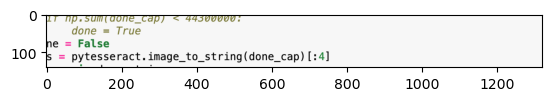

In [175]:
plt.imshow(env.get_done()[1])

In [176]:
env.get_done()

(False,
 array([[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        ...,
 
        [[207, 207, 207, 255],
         [207, 207, 207, 255],
         [207, 207, 207, 255],
         ...,
         [207, 207, 207, 255],
         [207, 207, 207, 255],
         [207, 207, 207, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 25

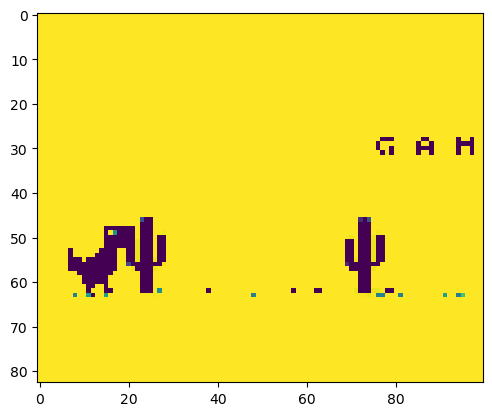

In [30]:
plt.imshow(np.array(env.get_observation())[0])

In [22]:
env.action_space.sample()

0

array([[[ 80,  55, 164, ..., 248, 171,  15],
        [102,  14, 162, ...,  40,  73, 140],
        [175, 226, 163, ..., 115,  14,  57],
        ...,
        [243, 211,  95, ...,  68,  81, 225],
        [162,  98, 139, ..., 249,  72,  95],
        [252,  93,  20, ..., 119,  75, 158]]], dtype=uint8)